# <p style="text-align: center;">AT-TPC Report

 ### <p style="text-align: right;">Authors:
<p style="text-align: right;">Ceulemans Andreas, Fracassetti Stefano, Youssef Ahmed
    

![Active Target](img/AT_drawing.png)

In [1]:
# Common import

import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, 
                             matthews_corrcoef, roc_curve, roc_auc_score, classification_report)

from helper_functions import *

#Fixing seed for reproducibility
np.random.seed(42)

# <span style="color:darkred">Description of the Project:</span> 


### Task
The main objective is to classify events aquired from an Active Target (simulated data), as being "beam" or "reaction" events. The idea is to implement a "software trigger" which would be able to effectively select only relevant data to save on disk for future analysis.

### Data Format
Data are saved in the file "Mg22_alphaalpha_digiSim.h5", which contains 2000 simulated events: even numbers are "reaction" events, while odd numbers are "beam" event.<br>
Each event is constitued by a point cloud of the active pads for that event.<br>
In turn, every hit pad is associated with a 4-tuple (x,y,z,q): x and y are the position of the hit pad on the detector plane, z is the coordinare associated to the beam axis, and q is the charge deposited on the pad.<br> 
Actually, there is an extra column associated with time (not needed since data already contains the z coordinate thanks to a pre-processing phase), and also an extra column of zeros, unnecessary for this analysis.<br>
The number of hit pads may vary for each event, ranging from around 20, up to a few hundred.

### Strategy
We will apply the ML techiques learned during the Talent Course, in order to analyse the data and reach the best performance possible.<br>
First there will be a section dedicated to data visualization, and in which we will discuss the general characteristic of the task. Afterwards, we will propose various approaches to tackle to problem, and show the results for each methods. Eventually, we will summarize and discuss the outcomes in the final section.

Models used in this project:
- Logistic Regression
- Random Forest
- Dense Neural Networks DNN
- K-Means

# <span style="color:darkred">Data Visualization:</span> 


### Let's have a look to the data file 

#### <p style="text-align: center;"> HDF5 file Format
First we load the data, which are stored as a hdf5 file, a (Hierarchical Data File) format designed to store and organize large amounts of data. The HDF5 file structure includes only two types of objects:
- Datasets, multidimensional arrays of a homogenous type
- Groups, container structures, that can hold Datasets or other groups

What's important to remember is that when opening a HDF5 in python through the command:
```
hf = f = h5py.File('./path/to/file', 'r')
```
we are creating this file objecct in which now  
**Groups work like Dictionaries, and DataSets work like NumPy arrays**

We can check the datasets/groups contained in the file by typing:
``` 
list(hf.keys())
```

#### <p style="text-align: center;"> Analysing "Mg22_alphaalpha_digiSim.h5"
In our case, there were no groups, but 2000 datasets each one corresponding to an event,  
each one with name *.  
Each event(key) is a 2D-array containing a 6 columns, and a variable number of rows (hit pads).


- We first want to visualise the lenght of the data. How many events are we dealing with?<br>
```
len(list(hf.keys()))
```
Here we can se that the there are 2000 events.
<br/><br/>
    
- It is interesting to print a few events type to see how many pads were written per event.<br>
```
list(hf.keys())
hf["Event_[i]"]
```   
We can see now that the keys have the name "Event_[#]", we can see the shape of the event.
It is possible to notice that the beam event have consistently more hit pads in respect to the reaction events.
<br/><br/>
- Eventually we will plot the entire set of information for an event to see the actual structre.<br>
```
hf["Event_[0]"].dtype
hf["Event_[0]"][:]    
```
Here we can see the actual DataSet for an event, and their respective fields and formats.

In [2]:
# Loading DataSet
local_data = './DataFiles/Mg22_alphaalpha_digiSim.h5'
hf = h5py.File(local_data, 'r')

# Lenght (number of events):  hf.keys()
print('>>> The number of event(keys) in the file is '  + str(len(hf.keys())) + "\n")

# Printing the single event info
print('  > The first 3 events "Reaction" type:')
for i in ([0,2,4]):
    print('    Event' + str(i) + ':' , hf["Event_[" + str(i) + "]"])
print("\n")

print('  > The first 3 events "Beam" type:')
for i in ([1,3,5]):
    print('    Event' + str(i) + ':' , hf["Event_[" + str(i) + "]"])
print("\n")

# Printing a full DataSet (event)
print(">>> Printing the first event DataSet \n")
print(hf["Event_[0]"].dtype, '\n') # Columns Labels and Formats
print(hf["Event_[0]"][:]) # First Event DataSet



>>> The number of event(keys) in the file is 2000

  > The first 3 events "Reaction" type:
    Event0: <HDF5 dataset "Event_[0]": shape (24,), type "|V48">
    Event2: <HDF5 dataset "Event_[2]": shape (24,), type "|V48">
    Event4: <HDF5 dataset "Event_[4]": shape (24,), type "|V48">


  > The first 3 events "Beam" type:
    Event1: <HDF5 dataset "Event_[1]": shape (195,), type "|V48">
    Event3: <HDF5 dataset "Event_[3]": shape (124,), type "|V48">
    Event5: <HDF5 dataset "Event_[5]": shape (269,), type "|V48">


>>> Printing the first event DataSet 

{'names':['x','y','z','t','A','trackID'], 'formats':['<f8','<f8','<f8','<i4','<f8','<i4'], 'offsets':[0,8,16,24,32,40], 'itemsize':48} 

[(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0)
 (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0)
 (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0)
 ( 2.45413303e+00, -1.45075214, 900., 450, 3.77884522e+03, 0)
 (-1.33514404e-05, -2.79990482, 900., 450, 1.1368678

### Storing the data

#### <p style="text-align: center;"> (Python) Nested List
This seems to be the most suited structure to handle these data, where every element of the list is an event DataSet. It is handy since avery data set have different lenght, and list are able to handle this without problem.
In the next cell, we import the data in a list.
We can show each element of a list, which correspond to a single event of the hdf5 file, checking that is the same as the hdf5 file.
    
#### <p style="text-align: center;"> (Pandas) DataFrame and Series, (Numpy) Array ?
These structure do not seem to respond nicely to our needs. 
    
- *(Pandas) DataFrame* are 2D structure of fixed lenght. In our case, we would need 3D array, where one variable has a variable lenght. Providing that we could stored "fake values" where data is missing, there is still the proble we can not store all the DataSet in a DataFrame structure type. However it is possible to store each event in a single and different DataFrace structure, or in a list of DataFrame type (not sure this is possible). There is no advantage to do this in respect to a list in the end, so we still opt on nested list.<br/><br/>
- *(Pandas) Series* are 1D arrays capable of holding data of any type (integer, string, float, python objects, etc.). The axis labels are collectively called index. Not adapted for our data.<br/><br/>   
- *(Numpy) Array* are a grid of values, all of the same type, and is indexed by a tuple of nonnegative integers. The number of dimensions is the rank of the array; the shape of an array is a tuple of integers giving the size of the array along each dimension. This structure is not adapt to host our data, since we need again a fixed dimension. In principle it would be possible, leaving NaN where data is missing. This method is inefficient. As for DataFrame, it would be possible to use this struture to store each event in a single and different Numpy Array
    

In [3]:
# Importing the data in a python list: AllDataList 
AllDataList = []
for i in range(len(hf.keys())):
    KeyString = "Event_[" + str(i) +"]"
    AllDataList.append(hf[KeyString][:]) # each list element is an event 2d matrix

# Printing a full DataSet (event)
print(">>> Printing the first event DataSet: \n")
print(AllDataList[0], '\n') # same as print(hf["Event_[0]"][:])
print(">>> Printing the first row of the first event:")
print(AllDataList[0][0], '\n')
print(">>> Printing the first feature (x) of the first row of Event_[0]:")
print(AllDataList[0][0][0], '\n')
    

>>> Printing the first event DataSet: 

[(-2.45412970e+00,  1.45075214, 834., 417, 6.73360577e+03, 0)
 (-1.33514404e-05,  2.79990482, 834., 417, 1.25854633e+04, 0)
 (-2.45412970e+00, -1.45075214, 834., 417, 1.70520808e+03, 0)
 ( 2.45413303e+00, -1.45075214, 900., 450, 3.77884522e+03, 0)
 (-1.33514404e-05, -2.79990482, 900., 450, 1.13686783e+04, 0)
 ( 2.45413303e+00,  1.45075214, 962., 481, 3.21076480e+03, 0)
 ( 4.90825081e+00, -5.70140886, 964., 482, 4.45706507e+01, 0)
 ( 2.45410442e+00,  7.05056143, 966., 483, 2.11128009e+01, 0)
 (-2.45413113e+00, -7.05056143, 984., 492, 1.90553867e+01, 0)
 (-4.90824747e+00,  5.70140886, 986., 493, 1.97473273e+01, 0)
 ( 4.90825081e+00,  5.70140886, 986., 493, 2.12675051e+01, 0)
 (-4.90824747e+00,  2.79990482, 990., 495, 4.76823698e+01, 0)
 (-4.90824747e+00, -5.70140886, 990., 495, 2.12226325e+01, 0)
 (-4.90824747e+00, -2.79990482, 990., 495, 2.63826991e+02, 0)
 ( 4.90825081e+00,  2.79990482, 990., 495, 4.01348998e+02, 0)
 (-2.45413113e+00,  7.05056143

### Labeling and cleaning

#### <p style="text-align: center;"> Labeling

The last step before deal with ML algorithm is to label and clean the data.
We know from the task description that the data come labeled:
- Reacion Event (label=1)
- Beam Event (label=0)  
    
Note that assigning 1 or 0 is a matter of choice, it is possible to do the opposite.
This choice reflect the idea that a reaction event is to keep, while a beam event must be rejected, so associated to a nul value.

#### <p style="text-align: center;"> Cleaning
   
This phase is rather simple, the events do no contain missing values. We only noticed that we deal with "empty" events. Event number (384, 430,484,914,1204 (numbers correspond to keys)) do not contain any value, so must be discarded.  
The DataSet we are going to analyse is formed by 1995 non-empty events.

In [4]:
# List of labels 
LabelsList = []
# Selecting Empty Events 
EmptyDataList = []

# List of not empty Events
DataList = []

for i in range(len(AllDataList)):
    if (len(AllDataList[i])>0): # Choosing only not empy events
        DataList.append(AllDataList[i])     
        if (i%2==0): # Reaction Event (even) --> label = 1
            LabelsList.append(1)
        else:        # Beam Event (odd)     --> label = 0
            LabelsList.append(0)
    else:
        EmptyDataList.append(i)
        

print("Dataset contains " + str(len(DataList)) + " non-empty events")
print("Data contains %i empty events, of indexes:"  % len(EmptyDataList),  EmptyDataList)




Dataset contains 1995 non-empty events
Data contains 5 empty events, of indexes: [384, 430, 484, 914, 1204]


REVISED UP TO THIS POINT. 13/08/2020

### Let's feed the ML! Time to eat data.

#### <p style="text-align: center;"> The perfect combination: Training - Validation - Testing
    
#### <p style="text-align: center;"> We do not eat everything, selecting relevant characteristics
    

### Last step before even starting: Visualize what we are dealing with!

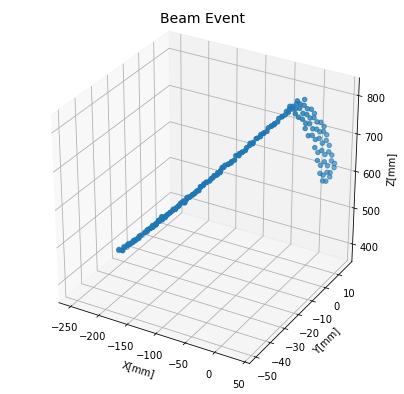

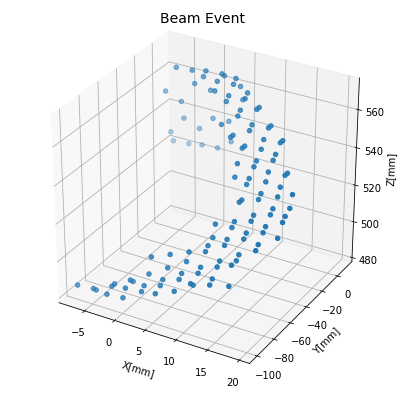

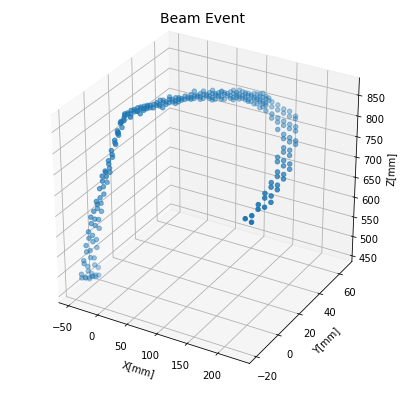

In [5]:
#Let's have a look at some data labeled as "beam"
for i in [1,3,5]:
    plot_3d_event(DataList,LabelsList,i)

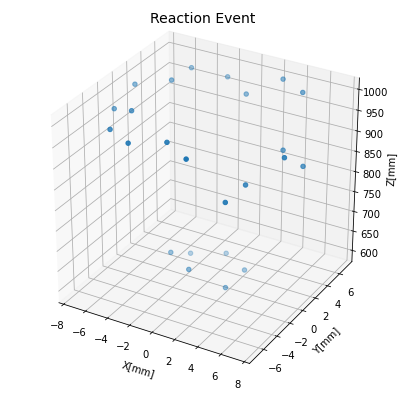

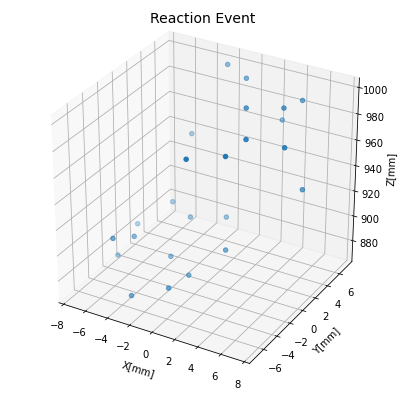

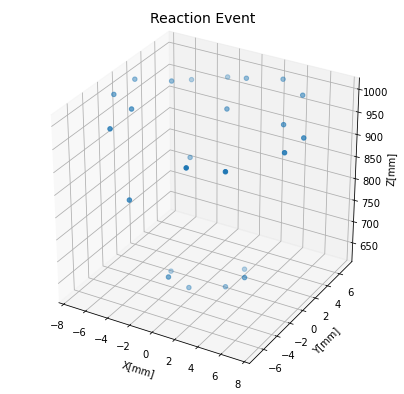

In [6]:
#Let's have a look at some data labeled as "reaction"
for i in [2,4,6]:
    plot_3d_event(DataList,LabelsList,i)

### Consideration on the data:
Data are 
```
"firstName": "John",
"lastName": "Smith",
"age": 25
```

# THIS SECTION SHOULD BE REMOVED LATER

In [7]:
AllData, Labels = load_data(hf)

x_idx = np.arange(len(AllData))
trainval_idx, test_idx, not_used1, not_used2 = train_test_split(x_idx, x_idx, test_size = 0.10)
train_idx, val_idx, not_used3, not_used4 = train_test_split(trainval_idx, trainval_idx, test_size = 0.10)
print("Dataset was divided into " + str(len(train_idx)) + " training events, " + str(len(val_idx)) + " validation events and " + str(len(test_idx)) + " test events")

Dataset contains 2000 events
Dataset contains 1995 non-empty events
Dataset was divided into 1615 training events, 180 validation events and 200 test events


In [8]:
MeanXPerEvent = np.zeros(len(AllData))
MeanYPerEvent = np.zeros(len(AllData))
MeanZPerEvent = np.zeros(len(AllData))
SumAPerEvent = np.zeros(len(AllData))
PadsPerEvent = np.zeros(len(AllData))
MeanWeightedXPerEvent = np.zeros(len(AllData))
MeanWeightedYPerEvent = np.zeros(len(AllData))
StDevXPerEvent = np.zeros(len(AllData))
StDevYPerEvent = np.zeros(len(AllData))
StDevZPerEvent = np.zeros(len(AllData))
FracClosePtsPerEvent = np.zeros(len(AllData)) # fraction of points satisfying x^2+y^2<100 in event



for i in range(len(AllData)):

    for j in range(len(AllData[i])):
        MeanXPerEvent[i] = MeanXPerEvent[i] + AllData[i][j][0]
        MeanYPerEvent[i] = MeanYPerEvent[i] + AllData[i][j][1]
        MeanZPerEvent[i] = MeanZPerEvent[i] + AllData[i][j][2]
        SumAPerEvent[i] = SumAPerEvent[i] + AllData[i][j][4]
        MeanWeightedXPerEvent[i] = MeanWeightedXPerEvent[i] + AllData[i][j][0]*AllData[i][j][4]
        MeanWeightedYPerEvent[i] = MeanWeightedYPerEvent[i] + AllData[i][j][1]*AllData[i][j][4]
        if (AllData[i][j][0]**2 + AllData[i][j][1]**2 < 100):
            FracClosePtsPerEvent[i] = FracClosePtsPerEvent[i] + 1 
        
    
    MeanXPerEvent[i] = MeanXPerEvent[i]/len(AllData[i])
    MeanYPerEvent[i] = MeanYPerEvent[i]/len(AllData[i])
    MeanZPerEvent[i] = MeanZPerEvent[i]/len(AllData[i])
    MeanWeightedXPerEvent[i] = MeanWeightedXPerEvent[i]/len(AllData[i])
    MeanWeightedYPerEvent[i] = MeanWeightedYPerEvent[i]/len(AllData[i])
    FracClosePtsPerEvent[i] = FracClosePtsPerEvent[i]/len(AllData[i])
    
    #second for loop for calculation of standard deviation
    for j in range(len(AllData[i])):
        StDevXPerEvent[i] = StDevXPerEvent[i] + (AllData[i][j][0]-MeanXPerEvent[i])**2
        StDevYPerEvent[i] = StDevYPerEvent[i] + (AllData[i][j][1]-MeanYPerEvent[i])**2
        StDevZPerEvent[i] = StDevZPerEvent[i] + (AllData[i][j][2]-MeanZPerEvent[i])**2
   
    StDevXPerEvent[i] = np.sqrt(StDevXPerEvent[i])/(len(AllData[i])-1)
    StDevYPerEvent[i] = np.sqrt(StDevYPerEvent[i])/(len(AllData[i])-1)
    StDevZPerEvent[i] = np.sqrt(StDevZPerEvent[i])/(len(AllData[i])-1)
    
    
        
    
    
    PadsPerEvent[i] = len(AllData[i])
    
print(SumAPerEvent)
print(MeanXPerEvent) 

[ 41292.86413493 322786.82279782  89094.2067578  ...  37851.88599835
  45542.97047786 260079.24714189]
[-3.33786011e-06 -6.60346445e+01 -3.33786011e-06 ... -4.39459217e+00
 -3.33786011e-06 -4.74462833e+00]


In [9]:
xSimple = np.zeros((len(AllData),5))

for i in range(len(AllData)):
    #standard x and y
    #xSimple[i][0] = MeanXPerEvent[i]
    #xSimple[i][1] = MeanYPerEvent[i]
    xSimple[i][0] = MeanZPerEvent[i]
    #alternative x and y
    xSimple[i][1] = StDevXPerEvent[i]
    #xSimple[i][1] = StDevYPerEvent[i]
    #xSimple[i][5] = StDevZPerEvent[i]
    xSimple[i][3] = SumAPerEvent[i]
    xSimple[i][4] = PadsPerEvent[i]
    xSimple[i][2] = FracClosePtsPerEvent[i]

xSimple_train = xSimple[train_idx][:]
xSimple_val = xSimple[val_idx][:]
xSimple_test = xSimple[test_idx][:]
Labels_train = Labels[train_idx]
Labels_val = Labels[val_idx]
Labels_test = Labels[test_idx]

#ar_nan = np.where(np.isnan(xSimple))
#print (ar_nan)
#ar_inf = np.where(np.isinf(xSimple))
#print (ar_inf)
#ar_neginf = np.where(np.isneginf(xSimple))
#print (ar_neginf)

print(xSimple[1204,:])

[6.32156250e+02 7.22232394e-01 3.28125000e-01 1.72528081e+05
 6.40000000e+01]


# Machine Learning

After loading the data and selecting the features to use, the actual machine learning can start.
To achieve the best results on the classification task, 
different models will be tested and their performance will be discussed.

### Logistic regression

Logistic regression is a widely used method for classification. 
It uses a sigmoid function to calculate the probability for an event to belong to a certain class.
The training procedure is used to optimize the cost function in terms of the parameters $\beta$ of the sigmoid function. In our case the standard implementation of [scikit-learn](https://scikit-learn.org/stable/index.html) is used. Remark that this implementation uses L2 regularization by default. <br>
The print_model_performance funtion is located in the helper functions file. It will be used to print the performance 
characteristics and display the confusion matrix for each model. This is done for both training and validation set separately.


Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9578947368421052
Precision: 0.928082191780822
Recall: 0.9938875305623472
F1-score: 0.9598583234946872
MCC: 0.9180729905117835


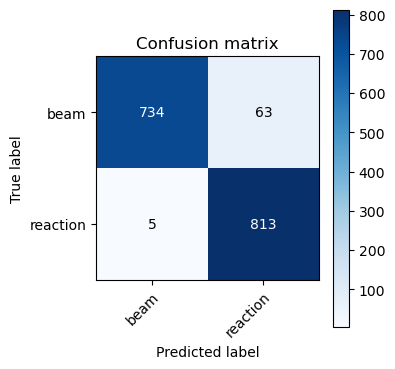


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9666666666666667
Precision: 0.9456521739130435
Recall: 0.9886363636363636
F1-score: 0.9666666666666666
MCC: 0.9342885375494071


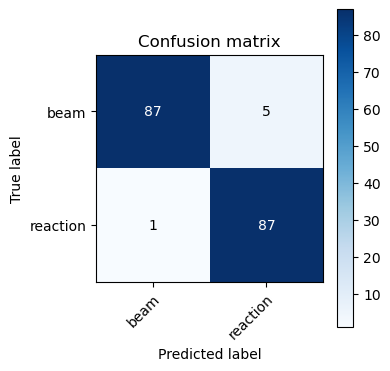

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(xSimple_train, Labels_train)
#print("validation set accuracy: {:.3f}".format(logreg.score(xSimple_val,Labels_val)))

LR0_pred_train = logreg.predict(xSimple_train)
LR0_pred_val = logreg.predict(xSimple_val)

print_model_performance(Labels_train,LR0_pred_train,"training")
print_model_performance(Labels_val,LR0_pred_val,"validation")

Not a bad start for our analysis! With an accuracy greater than 95% for both training and validation sets it classifies  quite well. It however seems to classify a significant amount of beam events as reaction events.

As an attempt to improve on these results the data will now be scaled. Scaling (or normalization) of the data
can improve the model performance quite significantly in some cases. Scikit-learn has a few different methods, of which the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) is used below. This scaler transforms each feature to have mean zero and unit variance. 

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(xSimple_train)

#Using the standardscaler
xSimple_train_stsc = scaler.transform(xSimple_train)
xSimple_val_stsc = scaler.transform(xSimple_val)

The logistic regression is repeated, now using the scaled data.

Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9969040247678018
Precision: 1.0
Recall: 0.9938875305623472
F1-score: 0.996934396076027
MCC: 0.9938265564282749


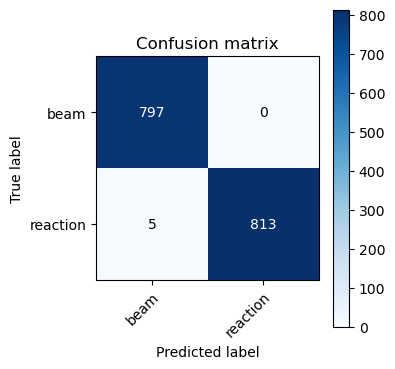


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9944444444444445
Precision: 1.0
Recall: 0.9886363636363636
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


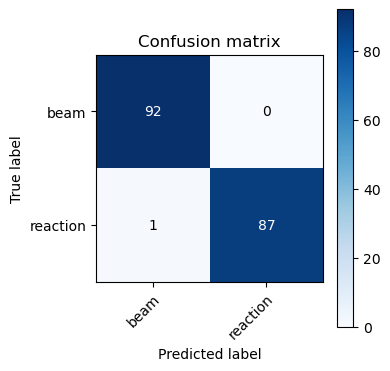

In [12]:
logreg2 = LogisticRegression()
logreg2.fit(xSimple_train_stsc, Labels_train)

LR_pred_train = logreg2.predict(xSimple_train_stsc)
LR_pred_val = logreg2.predict(xSimple_val_stsc)

print_model_performance(Labels_train,LR_pred_train,"training")
print_model_performance(Labels_val,LR_pred_val,"validation")

Comparing to previous results, the improvement is clear. The precision increased to over 99% 
on both training and validation data. This shows it is well worth looking into scaling features of your dataset.
For the remainder of this report all models will be trained using the scaled features.

### Random Forest

The random forest method combines the output a number of decision trees to make predictions. Each decision tree 
uses nodes with if-then-else structured conditions on the features that end up in a classification. 
A simple decision tree is displayed below.

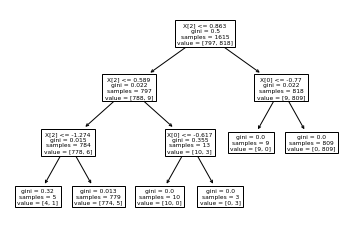

In [13]:
from sklearn import tree
DT = tree.DecisionTreeClassifier(max_depth=3)
DT = DT.fit(xSimple_train_stsc, Labels_train)
myplot = tree.plot_tree(DT)

To find the best random forest method, a gridsearch is performed with cross-validation on the training set. Both the random forest and the grid search are taken from scikit-learn. The precision is used to determine the optimal model in the grid search.

{'bootstrap': True, 'max_features': 2, 'n_estimators': 5}
RandomForestClassifier(max_features=2, n_estimators=5)
0.9939097393204829 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.9963487637107269 {'bootstrap': False, 'max_features': 2, 'n_estimators': 4}
0.9963189260386127 {'bootstrap': False, 'max_features': 2, 'n_estimators': 5}
0.9963265000748167 {'bootstrap': False, 'max_features': 2, 'n_estimators': 6}
0.998780487804878 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.9975534939398474 {'bootstrap': False, 'max_features': 3, 'n_estimators': 4}
0.995099506209786 {'bootstrap': False, 'max_features': 3, 'n_estimators': 5}
0.9975534939398474 {'bootstrap': False, 'max_features': 3, 'n_estimators': 6}
0.9938725123447554 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
0.9975534939398474 {'bootstrap': False, 'max_features': 4, 'n_estimators': 4}
0.9975534939398474 {'bootstrap': False, 'max_features': 4, 'n_estimators': 5}
0.9975534939398474 {'bootstrap'

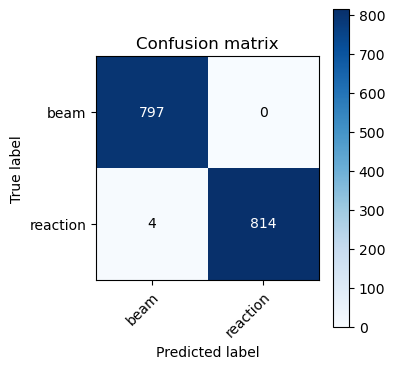


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9944444444444445
Precision: 1.0
Recall: 0.9886363636363636
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


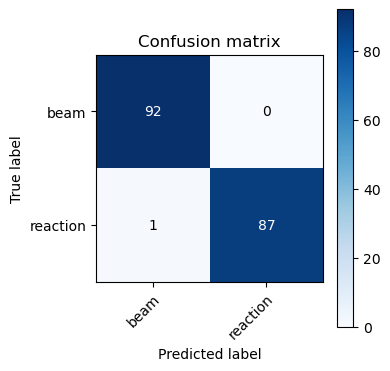

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [
{'n_estimators': [3,4,5,6], 'max_features': [2,3,4,5], 'bootstrap': [False,True]},
]
scoring = 'precision'
#scoring='neg_mean_squared_error'
#scoring='accuracy'
#scoring='recall'
RFC = RandomForestClassifier()
grid_search_imp = GridSearchCV(RFC, param_grid, cv=5, scoring=scoring)
grid_search_imp.fit(xSimple_train_stsc, Labels_train)
print(grid_search_imp.best_params_)
print(grid_search_imp.best_estimator_)

cvres = grid_search_imp.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

feature_importances = grid_search_imp.best_estimator_.feature_importances_
#print(sorted(zip(feature_importances, ["x","y","z","charge","nrofpads"]), reverse=True))

RFC_best = grid_search_imp.best_estimator_
RFC_pred_train = RFC_best.predict(xSimple_train_stsc)
RFC_pred_val = RFC_best.predict(xSimple_val_stsc)

print_model_performance(Labels_train,RFC_pred_train,"training")
print_model_performance(Labels_val,RFC_pred_val,"validation")

The best random forest estimator (found by grid search) reaches an
accuracy of over 99% on both training and validation set. Its results are very similar 
to the ones from the logistic regression. One could suspect the random forest estimator to overfit slightly,given its larger accuracy on the training set and the tendency for random forests to do so, 
but the limited size of the dataset prevents us from proving this. In case it does, one could also restrict the
'max_depth' of the trees to reduce overfitting.


### Dense Neural Network
The next model is a dense neural network (DNN). In this network the features act as input nodes. These are connected to neurons in a hidden layer, which have weights and biases. Based on their activation function and the inputs each neuron calculates an output as input for the next layer. When the output layer is reached the result are compared to the labels. By using backpropagation the weights and biases are updated in order to improve the correspondance of labels and output.

There are quite some parameters that can be tuned for a DNN, including number of hidden layers, number of neurons per layer, type of activation function, using batch normalization or dropout, which optimizer to use,...
No attempt is made to try all combinations. Instead we focused on a restricted number of simple models to select the best one. The one used finally is displayed below in Final Model

In [16]:
# Init the Sequential model
model = tf.keras.Sequential()
# Add Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(xSimple_train_stsc.shape[1],)))

# Add hidden layer
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))


# Add output layer.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Finally, compile the model and print a summary. Loss function and optimizer is set during compilation.
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                384       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,737
Non-trainable params: 128
_________________________________________________________________


The number of epochs and the size of the mini batches for training is set.

In [17]:
# Set parameters for the training run. The full data set is only 2000x5 doubles so large nr of epochs and
# small batch_size will still work well even on cpu
epochs = 20
batch_size = 16

The DNN is fitted on the training set. The performance on the validation set is also shown in the output. It should not take long to complete.

In [18]:
history = model.fit(
    x=xSimple_train_stsc,
    y=Labels_train,
    validation_data=(xSimple_val_stsc, Labels_val),
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/20
101/101 [==============================] - 0s 4ms/step - loss: 0.1001 - accuracy: 0.9734 - val_loss: 0.1215 - val_accuracy: 0.9944
Epoch 2/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0261 - accuracy: 0.9957 - val_loss: 0.0582 - val_accuracy: 0.9944
Epoch 3/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0186 - accuracy: 0.9969 - val_loss: 0.0340 - val_accuracy: 0.9944
Epoch 4/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0231 - accuracy: 0.9963 - val_loss: 0.0339 - val_accuracy: 0.9944
Epoch 5/20
101/101 [==============================] - 0s 2ms/step - loss: 0.0197 - accuracy: 0.9969 - val_loss: 0.0357 - val_accuracy: 0.9944
Epoch 6/20
101/101 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 0.9963 - val_loss: 0.0381 - val_accuracy: 0.9944
Epoch 7/20
101/101 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9957 - val_loss: 0.0406 - val_accuracy: 0.9944
Epoch 

After training the DNN, the predictions are created and the model performance is printed.
In addition the training history of the model is shown.

Model performance for training set:
--------------------------------------------------------

Accuracy: 0.9969040247678018
Precision: 1.0
Recall: 0.9938875305623472
F1-score: 0.996934396076027
MCC: 0.9938265564282749


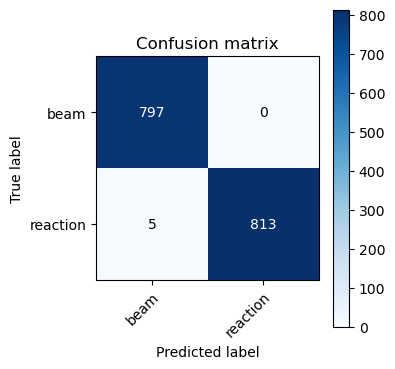


Model performance for validation set:
--------------------------------------------------------

Accuracy: 0.9944444444444445
Precision: 1.0
Recall: 0.9886363636363636
F1-score: 0.9942857142857142
MCC: 0.9889417905532354


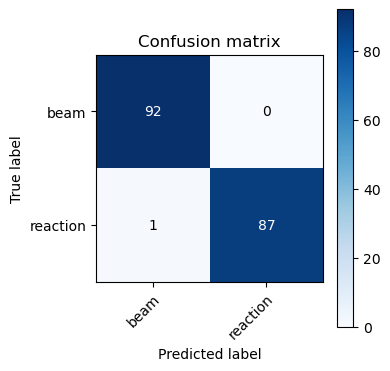

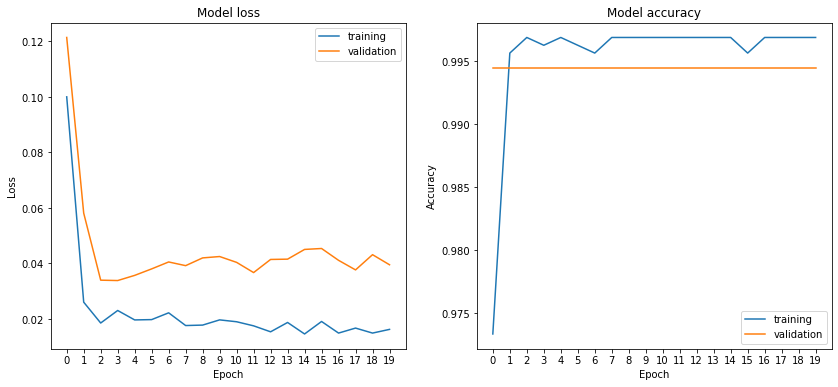

In [19]:
#the predictions contain a number in [0,1] these get mapped to 1 if >0.5 and to 0 if <0.5
#This way  a hard classifier is created
DNN_pred_train_pre = model.predict(xSimple_train_stsc)
DNN_pred_val_pre = model.predict(xSimple_val_stsc)
DNN_pred_train = DNN_pred_train_pre > 0.5
DNN_pred_val = DNN_pred_val_pre > 0.5


print_model_performance(Labels_train,DNN_pred_train,"training")
print_model_performance(Labels_val,DNN_pred_val,"validation")

make_nn_plots(history)


Also this model performs well, its predictions are consistent with the logistic regression method. 

### K-Means
K-Means (KM) is a method that tries to find and separate clusters in the dataset.
One main difference to the other methods used in this report is that KM is an unsupervised learning method (it does not use the labels). Nevertheless, one can still try to assign each KM-cluster to a class and see what the results are.

#### Elbow method for K-Means
One parameter KM requires is the number of clusters to search for. An obvious choice would be to take the number of clusters equal to the number of classes in the dataset (two). However there exists a way to look for the optimal number of clusters called the elbow method. The KM method tries to minimize the 'inertia', which is the sum of squared error inside a cluster. It is however so that we cannot look for the minima of this in function of the number of clusters, as more clusters always reduce the inertia. Therefore one looks for the 'elbow' of this plot, the number of clusters at which the inertia is lowered significantly, which results in a kink in the curve (which resembles an elbow).

This approach is based on [Geron's notebook](https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb)
        (search for 'finding the optimal number of clusters')

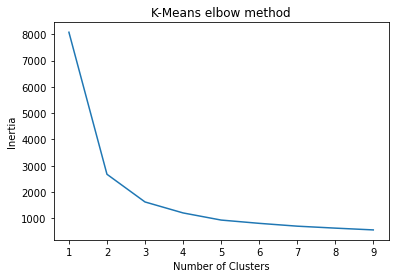

In [23]:
from sklearn.cluster import KMeans
nr_clusters = range(1,10)
inertia = []

for k in nr_clusters:
    km = KMeans(n_clusters=k)
    km.fit(xSimple_train_stsc)
    inertia.append(km.inertia_)

inertia
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia') #sum of squared error
plt.title('K-Means elbow method')

plt.plot(nr_clusters,inertia)


From the figure above it seems there are 
two suitable candidates for the optimal number of clusters k$\in$[2,3].

Fitting KM for these two cases is straightforward, however the cluster predictions still need to be mapped to class predictions. This means assigning a KM cluster to either beam or reaction events. KM itself does not tell us how to 
map these, so the best mapping is defined as the one that gives the highest accuracy. To do so, the accuracies are
determined for all possible mappings, excluding the trivial ones that map all clusters to the same class.

# Conclusions